<a href="https://colab.research.google.com/github/santiviquez/noisy-human-recognition/blob/main/sound_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Non-Speech Sound Classification
Classification of audio data remains a challenge
for data scientists, as the raw signal requires multiple stages
of processing. In the field of sound classification, this paper
focuses on human non-speech sounds, exploring both processing
techniques for audio data, and deep learning architectures
that are fit for producing good results on limited examples.
We find that a CNN which receives Mel-spectrograms and the
derived deltas as input produces the best results. We discuss the
effectiveness of augmentations and windowing, as these prove
to impair model performance. Potential contributions are the
identification of baseline models for the detection of non-speech
sounds that are harder to recognize compared to speech. Most
importantly, the goal is to explore methods for the analysis of
human data.
### Datasets
- [ESC-50 dataset]("https://github.com/karoldvl/ESC-50/archive/master.zip"). Using only non-speech humman sounds.

### Models
- Classical ML Models:
  - Random Forest
  - SVM
  - XGBoost
- CNN-Based Models:
  - CNN on Mel spectrogram
  - CNN on Mel spectrogram + Deltas
  - CNN on Mel spectrogram + Deltas + Augmentations
  - CNN on Mel spectrogram + Deltas + Trimmed Audios
- CNN-LSTM

### Demo
Test the model at: [link]("https://huggingface.co/spaces/santiviquez/noisy_human")

### Integrants
Name, Matricola, Email respectively
- Santiago Víquez Segura, 2048722, santiago.viquezsegura@studenti.unipd.it
- Ivan Padezhki, 2041499, ivandragomirov.padezhki@studenti.unipd.it

## Dependencies

In [ ]:
import os
import shutil
import urllib.request
import zipfile
import glob
import pandas as pd
import numpy as np
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import librosa
import librosa.display
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import svm
import xgboost as xgb
import time
import seaborn as sns

## Download Dataset

In [ ]:
def download_dataset(name):
    """
    Download the dataset into current working directory.
    
    Originally taken from https://nbviewer.org/github/karoldvl/paper-2015-esc-dataset/blob/
    master/Notebook/ESC-Dataset-for-Environmental-Sound-Classification.ipynb#Setup
    Additional modifications were applied to make it work with Python 3
    """
    if not os.path.exists(name):
        os.mkdir(name)
        urllib.request.urlretrieve(f'https://github.com/karoldvl/{name}/archive/master.zip', f'{name}/{name}.zip')

        with zipfile.ZipFile(f'{name}/{name}.zip') as package:
            package.extractall(f'{name}/')

        os.unlink(f'{name}/{name}.zip')        

        for src in glob.glob(f'{name}/{name}-master/*'):
            shutil.move(src, '{0}/{1}'.format(name, os.path.basename(src)))

        shutil.rmtree(f'{name}/{name}-master')

download_dataset('ESC-50')

In [ ]:
ls ESC-50

audio/     LICENSE  pytest.ini  requirements.txt
esc50.gif  meta/    README.md   tests/


## Sample Dataset: Non-Speech Human Sounds

In this project we are going to fucus at identifying non-speech human sounds. Such as: `crying_baby`, `sneezing`, `clapping`, etc. So we are going to filter these categories from the main esc50 dataset.

In [ ]:
esc50 = pd.read_csv("ESC-50/meta/esc50.csv")

human_cats = ['crying_baby', 'sneezing', 'clapping', 
              'breathing', 'coughing', 'footsteps', 
              'laughing', 'brushing_teeth', 'snoring', 
              'drinking_sipping']

esc50_human = esc50[esc50["category"].isin(human_cats)].reset_index(drop=True)
esc50_human['old_target'] = esc50_human['target']

new_classes = [i for i in range(10)]
old_classes = esc50_human.target.drop_duplicates().values
map_old_new_classes = dict(zip(old_classes, new_classes))

#esc50_human = esc50[esc50["category"].isin(human_cats)].reset_index(drop=True)
#esc50_human['old_target'] = esc50_human['target']
esc50_human = esc50_human.replace({"target": map_old_new_classes})

In [ ]:
esc50_human.head()

,filename,fold,target,category,esc10,src_file,take,old_target
0,1-104089-A-22.wav,1,0,clapping,False,104089,A,22
1,1-104089-B-22.wav,1,0,clapping,False,104089,B,22
2,1-105224-A-22.wav,1,0,clapping,False,105224,A,22
3,1-110537-A-22.wav,1,0,clapping,False,110537,A,22
4,1-115920-A-22.wav,1,0,clapping,False,115920,A,22


Create trimmed versions of the recordings, then split them into frames and keep only frames of same size (i.e. kick out last two frames which are either way empty)

In [ ]:
from librosa.util import fix_length
import soundfile as sf

trim_data_dic = {}
# Load some audio
for i, row in esc50_human.iterrows(): 
    filename = row["filename"]
    fold = int(row["fold"])
    target = row["target"]
    category = row["category"]
    frame_index = 0
    filename = filename.replace('.wav', '')
    y, sr = librosa.load("ESC-50/audio/" + filename + '.wav')
    # Trim the beginning and ending silence
    # split into non-silent windows
    frame_len = len(y) // 3
    overlap = frame_len // 2
    c = 0
    current_len = 0
    for _ in range(0, len(y), overlap):
        frame = y[c:frame_len + c]
        c += overlap
        frame_title = filename + '_' + str(frame_index) + '_trim.wav'
        # pad to 1 second
        frame = fix_length(frame, size = 1*sr)
        sf.write('ESC-50/audio/' + frame_title, frame, sr)
        parent_filename = filename + '.wav'
        trim_data_dic[frame_title] = {"parent_filename":parent_filename, "filename":frame_title, "target":target, "category":category, "fold":fold}
        frame_index += 1

esc50_human_frames = pd.DataFrame(trim_data_dic).T.reset_index(drop=True)
esc50_human_frames.head()

,parent_filename,filename,target,category,fold
0,1-104089-A-22.wav,1-104089-A-22_0_trim.wav,0,clapping,1
1,1-104089-A-22.wav,1-104089-A-22_1_trim.wav,0,clapping,1
2,1-104089-A-22.wav,1-104089-A-22_2_trim.wav,0,clapping,1
3,1-104089-A-22.wav,1-104089-A-22_3_trim.wav,0,clapping,1
4,1-104089-A-22.wav,1-104089-A-22_4_trim.wav,0,clapping,1


## Exploratory Analysis

Let's start by looking at a single audio file of a baby crying.

In [ ]:
def plot_example(filename, taudio=None, augmented_title="raw"):
    RATE = 22050   # All recordings in ESC are 44.1 kHz
    FRAME = 512    # Frame size in samples
    fig, axes = plt.subplots(3, 1)
    
    if augmented_title == "raw":
        spf = wave.open("ESC-50/audio/" + filename, "r")
        # Extract Raw Audio from Wav File
        signal_raw = spf.readframes(-1)
        print("raw")
    else:
        signal_raw = taudio
        print("aug")
    
    signal = np.frombuffer(signal_raw, "int16")
    print(signal)
    category = esc50_human[esc50_human.filename == filename].category.values[0]

    axes[0].set_title(f"{category} - {augmented_title} - file: {filename}")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Amplitude")
    axes[0].plot(np.arange(0, len(signal)) / RATE, signal)

    # Compute Melspectrogram Features
    signal = (np.frombuffer(signal, dtype="int16") + 0.5) / (0x7FFF + 0.5) # convert to float
    signal = librosa.feature.melspectrogram(y=signal, sr=RATE, hop_length=FRAME)
    signal = librosa.power_to_db(signal, ref=np.max)
    img = librosa.display.specshow(signal, x_axis='time', y_axis='linear', sr=RATE, cmap='RdBu_r', ax=axes[1])
    axes[1].set_title('Melspectrogram')
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Frequency(Hz)")
    
    # Compute MFCC
    mfcc = librosa.feature.mfcc(S=signal, sr=RATE, n_mfcc=13)
    img = librosa.display.specshow(mfcc, x_axis='time',sr=RATE, cmap='RdBu_r', ax=axes[2])
    axes[2].set_title('MFCC')
    axes[2].set_ylabel("MFCC Coefficients")
    axes[2].set_xlabel("Time (s)")
    fig.tight_layout()
    plt.show()

raw
[  4   4   4 ... 175 190 200]


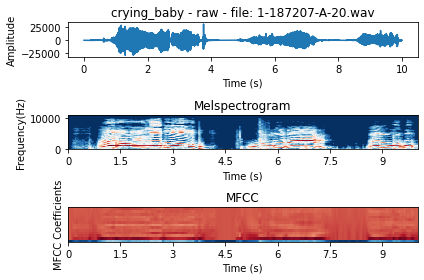

In [ ]:
filename = "1-187207-A-20.wav"
plot_example(filename)
IPython.display.Audio("ESC-50/audio/" + filename)

Now, let's plot the amplitude and melspectrogram of one example per category.

In [ ]:
def add_subplot_axes(ax, position):
    """
    Originally taken from https://nbviewer.org/github/karoldvl/paper-2015-esc-dataset/blob/
    master/Notebook/ESC-Dataset-for-Environmental-Sound-Classification.ipynb#Setup
    Additional modifications were applied to make it work with Python 3
    """
    box = ax.get_position()
    
    position_display = ax.transAxes.transform(position[0:2])
    position_fig = plt.gcf().transFigure.inverted().transform(position_display)
    x = position_fig[0]
    y = position_fig[1]
    
    return plt.gcf().add_axes([x, y, box.width * position[2], box.height * position[3]])

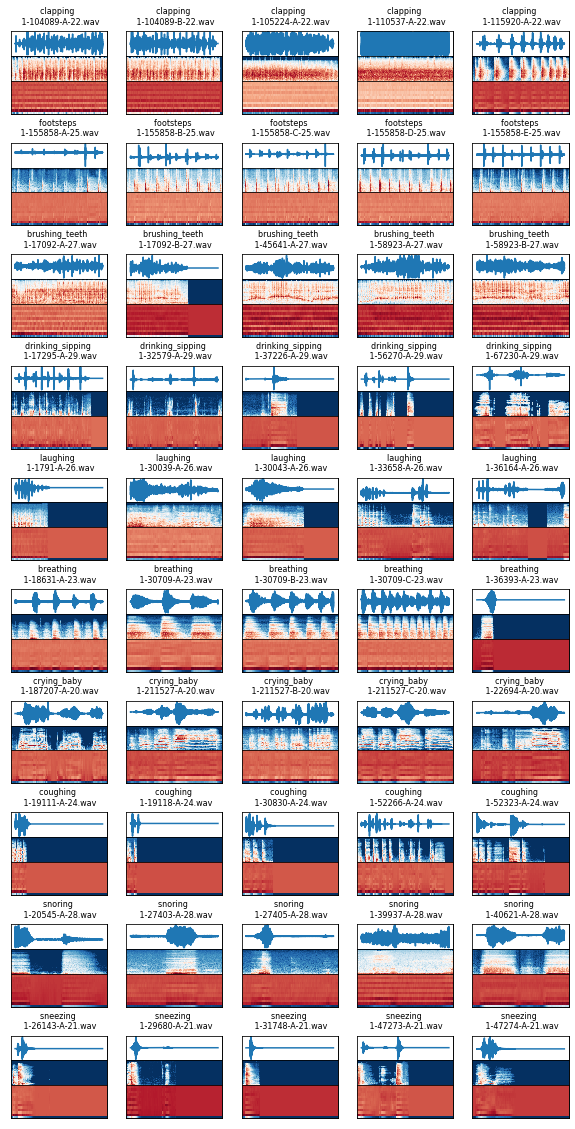

In [ ]:
def plot_clip_overview(audio, category, filename ,ax):
    RATE = 44100   # All recordings in ESC are 44.1 kHz
    FRAME = 512    # Frame size in samples
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax_waveform = add_subplot_axes(ax, [0.0, 0.7, 1.0, 0.3]) # [left, bottom, width, height]
    ax_spectrogram = add_subplot_axes(ax, [0.0, 0.4, 1.0, 0.3])
    ax_mfcc = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.4])
    
    # Extract Raw Audio from Wav File
    signal_raw = audio.readframes(-1)
    signal = np.frombuffer(signal_raw, "int16")
    ax_waveform.plot(np.arange(0, len(signal)) / float(RATE), signal)
    ax_waveform.get_xaxis().set_visible(False)
    ax_waveform.get_yaxis().set_visible(False)
    ax_waveform.set_title('{0} \n {1}'.format(category, filename), {'fontsize': 8}, y=1.03)

    # Compute Melspectrogram Features
    signal = (np.frombuffer(signal_raw, dtype="int16") + 0.5) / (0x7FFF + 0.5) # convert to float
    signal = librosa.feature.melspectrogram(y=signal, sr=RATE, hop_length=FRAME)
    signal = librosa.power_to_db(signal, ref=np.max)
    librosa.display.specshow(signal, x_axis='time', y_axis='linear', sr=RATE, cmap='RdBu_r',ax=ax_spectrogram)
    ax_spectrogram.get_xaxis().set_visible(False)
    ax_spectrogram.get_yaxis().set_visible(False)
    
    # Compute MFCC
    mfcc = librosa.feature.mfcc(S=signal, sr=RATE, n_mfcc=13)
    librosa.display.specshow(mfcc, x_axis='time', sr=RATE, cmap='RdBu_r', ax=ax_mfcc)
    ax_mfcc.get_xaxis().set_visible(False)
    ax_mfcc.get_yaxis().set_visible(False)
    
categories = esc50_human.category.unique()
categories_len = len(categories)
clips_shown = 5
f, axes = plt.subplots(categories_len, clips_shown,
                       figsize=(clips_shown * 2, categories_len * 2), 
                       sharex=True, 
                       sharey=True)
f.subplots_adjust(hspace = 0.35)

for i, c in enumerate(categories):
    for j in range(0, clips_shown):
        filename = esc50_human[esc50_human.category == c].filename.iloc[j]
        spf = wave.open("ESC-50/audio/" + filename, "r")
        plot_clip_overview(spf, c, filename, axes[i, j])

## Creating the MFCC dataset

In this section we will compute the MFCC coefficients for every sample in the `esc50_human` with the purpose of using is as input for machine learning classifiers.

In [ ]:
def compute_features(df, is_augmentation=False):
    RATE = 44100   # All recordings in ESC are 44.1 kHz
    FRAME = 512    # Frame size in samples
    dataloader_dict = {}
    for i, row in df.iterrows():  
        filename = row["filename"]
        fold = int(row["fold"])
        target = row["target"]
        category = row["category"]

        spf = wave.open("ESC-50/audio/" + filename, "r")
        signal_raw = spf.readframes(-1)
        
        if is_augmentation:
            
            # draft of this part is at the end!
            
            # TODO: compute different data augmentations here on the raw_signal and then
            # compute the Melspectrogram and MFCC of the augmented data
            # others modifications to the code need to be implemented
            pass
        
        # Compute Melspectrogram Features
        signal = (np.frombuffer(signal_raw, dtype="int16") + 0.5) / (0x7FFF + 0.5) # convert to float
        signal = librosa.feature.melspectrogram(y=signal, sr=RATE, hop_length=FRAME)
        signal = librosa.power_to_db(signal, ref=np.max)
        # Compute MFCC
        mfcc = librosa.feature.mfcc(S=signal, sr=RATE, n_mfcc=13)

        dataloader_dict[i] = {"filename":filename, "data":mfcc, "target":target, "category":category,"fold":fold}
    return dataloader_dict

In [ ]:
def train_loader(dic, fold):
    X_val = []
    X_train = []
    y_val = []
    y_train = []

    for id, subj in dic.items():

        if subj["fold"]!=fold:
            X_train.append(subj['data'])
            y_train.append(subj['target'])
                
        if subj["fold"]==fold:
            X_val.append(subj['data'])
            y_val.append(subj['target'])
    
    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val)

In [ ]:
dataloader_dic = compute_features(esc50_human)
X_train, y_train, X_val, y_val = train_loader(dataloader_dic, fold=1)

`X_train` has a shape of `(320, 13, 431)` meaning that we have 320 examples of shape `(13, 431)` we can think about each example as an image of that size.

## Baseline models
In the following section we will trying some machine learning classifiers (eg: Random Forest, SVM, XGBoost) and then compare those results to much more complex models such a CNN.

In [ ]:
# reshape to 2 dimensions, as Random forest does not accept 3D input
nsamples, nx, ny = X_train.shape
X_train_2d = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_val.shape
X_val_2d = X_val.reshape((nsamples,nx*ny))

In [ ]:
def eval_and_plot(model, X_val, y_true, labels):
    y_pred = model.predict(X_val)
    model_acc = accuracy_score(y_true, y_pred)
    conf_mat = confusion_matrix(y_true, y_pred)
    
    ax = sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
    ax.set(xlabel="Predicted Category", ylabel="True Category")
    
    return model_acc

In [ ]:
plot_labels = ['crying_baby', 'sneezing', 'clapping', 
              'breathing', 'coughing', 'footsteps', 
              'laughing', 'brushing_teeth', 'snoring', 
              'drinking_sipping']

### Random Forrest Classifier

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth':[5, 10, 15]
}

rand_forest = RandomForestClassifier(random_state=0)
clf = GridSearchCV(rand_forest, param_grid, cv = 5)

training_start_time = time.time()
clf.fit(X_train_2d, y_train)
training_stop_time = time.time()

runtime = training_stop_time - training_start_time

Validation Accuracy of a Random Forest Classifier 0.4875
Training Time: 51.02493071556091


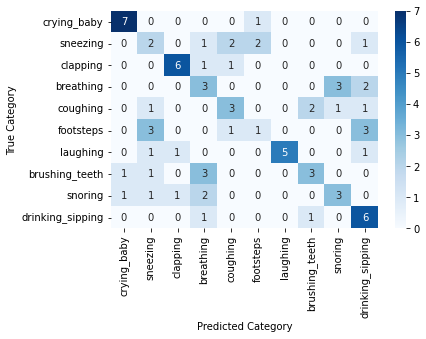

In [ ]:
forest_acc = eval_and_plot(clf, X_val_2d, y_val, plot_labels)
print("Validation Accuracy of a Random Forest Classifier", forest_acc)
print(f"Training Time: {runtime}")

### SVM

Validation Accuracy of an SVM 0.3875
Training Time: 47.03242778778076


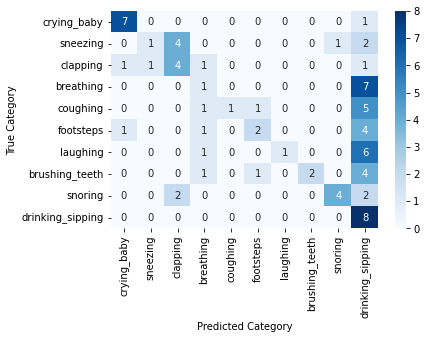

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
svm_grid = GridSearchCV(svm.SVC(random_state = 0), param_grid)
  
# fitting the model for grid search
training_start_time = time.time()
svm_grid.fit(X_train_2d, y_train)
training_stop_time = time.time()

runtime = training_stop_time - training_start_time

svm_acc = eval_and_plot(svm_grid, X_val_2d, y_val, plot_labels)
print("Validation Accuracy of an SVM", svm_acc)
print(f"Training Time: {runtime}")

### XGBoost

Validation Accuracy of an XGBoost 0.425
Training Time: 934.8211393356323


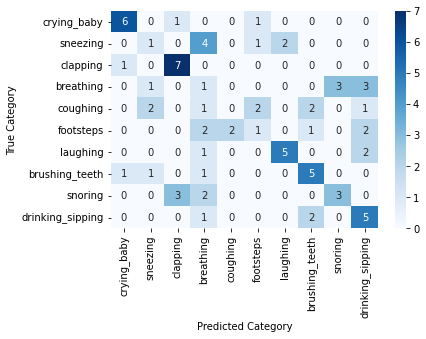

In [ ]:
param_grid = {
    'max_depth': [5, 10, 15]
}

boost = xgb.XGBClassifier(random_state=0)

xgb_grid = GridSearchCV(boost, param_grid)
training_start_time = time.time()
xgb_grid.fit(X_train_2d, y_train)
training_stop_time = time.time()

runtime = training_stop_time - training_start_time

xgb_acc = eval_and_plot(xgb_grid, X_val_2d, y_val, plot_labels)
print("Validation Accuracy of an XGBoost", xgb_acc)
print(f"Training Time: {runtime}")

## Neural Networks

### Data Preparation for NN

In [ ]:
%pip install torchaudio_augmentations # for google-colab
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as transforms
import torchaudio
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from torchaudio_augmentations import Compose, ComposeMany, Noise, Gain, PolarityInversion, Delay, HighLowPass, RandomApply

# Avoiding nondeterministic algorithms for reproducibility purposes
torch.use_deterministic_algorithms(False)
random.seed(0)
np.random.seed(0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)
torch.manual_seed(42)

In [ ]:
def get_dataloader_dict(df):
    dataloader_dict = {}
    for i, row in df.iterrows():  
        filename = row["filename"]
        fold = int(row["fold"])
        target = row["target"]
        category = row["category"]
        
        waveform, sample_rate = torchaudio.load("ESC-50/audio/" + filename, normalize=True)
        dataloader_dict[i] = {"filename":filename, "data":waveform, "target":target, "category":category,"fold":fold}
    return dataloader_dict

In [ ]:
def get_time_dataloader_dict(df):
  dataloader_dict = {}
  for i, row in df.iterrows():
    data = []
    filename = row["parent_filename"]
    fold = int(row["fold"])
    target = row["target"]
    category = row["category"]
    for j in range(0, 6):
      trim_filename = filename.replace(".wav", "") + "_" + str(j) + "_trim.wav" 
      waveform, sample_rate = torchaudio.load("ESC-50/audio/" + trim_filename, normalize=True)
      data.append(waveform)
    # concatenate all sequences of same audio as channels of tensor
    data_tensor = torch.cat(data, dim=0)
    dataloader_dict[i] = {"filename":filename, "data":data_tensor, "target":target, "category":category,"fold":fold}
  return dataloader_dict

In [ ]:
def train_val_loader(dic, fold):
    X_val = []
    X_train = []
    y_val = []
    y_train = []

    for id, subj in dic.items():

        if subj["fold"]!=fold:
            X_train.append(subj['data'])
            y_train.append(subj['target'])
                
        if subj["fold"]==fold:
            X_val.append(subj['data'])
            y_val.append(subj['target'])
    
    return X_train, np.array(y_train), X_val, np.array(y_val)

In [ ]:
class ESCHDataset(Dataset):
    def __init__(self, data, targets, augmentation=None, transform_1=None, transform_2=None):
        self.data = data
        self.targets = targets
        self.augmentation = augmentation
        self.transform_1 = transform_1
        self.transform_2 = transform_2
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.augmentation:
            x = self.augmentation(x)
        
        if self.transform_1:
            x = self.transform_1(x)
            if self.transform_2:
                x_1 = self.transform_2(x)
                if self.augmentation:
                    x = torch.cat((x, x_1), 1)
                else:
                    x = torch.cat((x, x_1), 0)                
        
        return x, y
    
    def __len__(self):
        return len(self.data)

### Training Functions

In [ ]:
# Function to save the model - best model in terms of validation accuracy
def save_model(model, model_name):
  if not os.path.exists("./models/"):
    os.mkdir("models/")
  path = f"./models/{model_name}_.pth" 
  torch.save(model.state_dict(), path)

In [ ]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
        # print(f'Reset trainable parameters of layer = {layer}')
        layer.reset_parameters()

In [ ]:
# Class oringinally taken from https://stackoverflow.com/a/73704579
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)    
    return acc

In [ ]:
def train(num_epochs, training_loader, validation_loader, model, model_name_fold, optimizer, scheduler, is_augmented):
    best_accuracy_value = 0.0
    train_loss_list = []
    val_loss_list = []
    #early_stopper = EarlyStopper(patience=20, min_delta=0.1)

    
    print("Begin Training")
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_train_accuracy = 0.0
        running_val_loss = 0.0
        running_val_accuracy = 0.0
        total = 0

        # training loop
        model.train()
        for i, data in enumerate(training_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            if is_augmented == True:
                inputs = torch.flatten(inputs, start_dim=0, end_dim=1)
                labels = labels.repeat(5)
            #labels = labels.to(torch.long)
            #inputs = inputs.to(torch.float32)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            train_loss = criterion(outputs, labels)
            train_loss.backward()
            optimizer.step()

            # track train loss
            running_train_loss += train_loss.item()
            # make predictions on training data
            # _, train_preds = torch.max(outputs, 1)
            # track train f1-score
            train_acc = multi_acc(outputs, labels)
            running_train_accuracy += train_acc.item()

        # calculate train loss and train accuracy values
        train_loss_value = running_train_loss / len(training_loader)
        train_accuracy_value = running_train_accuracy / len(training_loader)

        # validation loop
        with torch.no_grad():
            model.eval()
            for data in validation_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)

                #_, val_preds = torch.max(outputs, 1)
                running_val_loss += val_loss.item()
                val_acc = multi_acc(outputs, labels)
                running_val_accuracy += val_acc.item()
        
        # calculate val loss and val f1-score values
        val_loss_value = running_val_loss / len(validation_loader)
        val_accuracy_value = running_val_accuracy / len(validation_loader)
        
        # call lr scheduler
        if scheduler != None:
            scheduler.step(val_loss_value)
            print(f"Current lr:{scheduler.optimizer.param_groups[0]['lr']}")

        # Save model is val f1-score is the best
        if val_accuracy_value > best_accuracy_value:
            save_model(model, model_name_fold)
            best_accuracy_value = val_accuracy_value

        # Print the statistics of the epoch 
        train_loss_list.append(train_loss_value)
        val_loss_list.append(val_loss_value)
        
        # print(f'Current lr: {optimizer.param_groups[0]["lr"]}')
        print('Completed training batch', epoch, 'Train Loss: %.4f' %train_loss_value, 
              'Val Loss: %.4f' %val_loss_value, 'Train Accuracy: %.4f' %train_accuracy_value, 
              'Val Accuracy: %.4f' %val_accuracy_value)
        
        # stop if val loss has no t decreased in the last (# of patience) epochs
        #if early_stopper.early_stop(val_loss_value):
        #    print("Early Stopping")
        #    break

    print('Finished Training')
    
    # plot loss for training and validation for the current batch
    plt.plot(train_loss_list[0:-1])
    plt.plot(val_loss_list[0:-1])
    plt.show()
    
    # pass back the accuracy from the best model
    return train_loss_list, val_loss_list, best_accuracy_value

In [ ]:
# function for cross-validation
def train_cv(num_epochs,
             df,
             model, 
             lr=0.001,
             model_name=None,
             optimizer=None,
             scheduler=None,
             augmentation=None,
             transform_1=None,
             transform_2=None,
             is_augmented=False,
             cnn_lstm=False,
             n_folds=5):
    '''
    Inputs required/define:
    - number of training epochs (num_epochs) per fold
    - df is input data
    - n_folds - use 5-fold cross-validation
    - model is the defined model we use for training and validation
    - model_name asks for how to save the model
    - transformations is a torch.Compose object computing MFCCs / or also augmentations
    '''
    
    # to store loss and accuracy of each fold
    train_losses = {}
    val_losses = {}
    batch_times = []
    accuracies = []
    
    # open data
    dataloader_dic = get_dataloader_dict(df)
    
    for i in range(1, n_folds+1):
        # reset model weights to avoid weights leakage between folds
        model.apply(reset_weights)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        #scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)
        scheduler = None

        print(f'FOLD # {i}')
        model_name_fold = str(model_name) + '_fold_' + str(i)
        training_start_time = time.time()
        
        X_train, y_train, X_val, y_val = train_val_loader(dataloader_dic, fold=i)
        
        if cnn_lstm:
          train_dataset = ESCHTIMEDataset(X_train, 
                                    y_train, 
                                    augmentation=augmentation, 
                                    transform_1=transform_1,
                                    transform_2=transform_2)
        
          val_dataset = ESCHTIMEDataset(X_val,
                          y_val,
                          transform_1=transform_1,
                          transform_2=transform_2)
        else:
          train_dataset = ESCHDataset(X_train, 
                                      y_train, 
                                      augmentation=augmentation, 
                                      transform_1=transform_1,
                                      transform_2=transform_2)
          
          val_dataset = ESCHDataset(X_val,
                            y_val,
                            transform_1=transform_1,
                            transform_2=transform_2)
        

        train_loader = DataLoader(train_dataset, batch_size=80, drop_last=True,
                                 worker_init_fn=seed_worker, 
                                 generator=g)
        

        val_loader = DataLoader(val_dataset, batch_size=80, drop_last=True,
                                 worker_init_fn=seed_worker, 
                                 generator=g)
        
        # train for current fold of data
        # train(num_epochs, training_loader, validation_loader, model, model_name_fold)
        train_loss_fold, val_loss_fold, best_accuracy = train(num_epochs, 
                                                              train_loader, 
                                                              val_loader, 
                                                              model, 
                                                              model_name_fold,
                                                              optimizer,
                                                              scheduler,
                                                              is_augmented)
        
        # stop time and print total fold runtime 
        training_stop_time = time.time()
        batch_runtime = training_stop_time - training_start_time
        batch_times.append(batch_runtime)
        
        print(f'Fold {i} runtime: {batch_runtime}')
        
        # plot loss for training and validation
        #plt.plot(train_loss_fold[0:-1])
        #plt.plot(val_loss_fold[0:-1])
        
        # save loss and acc in dictionary for later prediction and comparison
        train_losses[i] = train_loss_fold
        val_losses[i] = val_loss_fold
        
        # at the end of every fold, appemd the best accuracy 
        accuracies.append(best_accuracy)
      

    mean_acc = sum(accuracies)/len(accuracies) # and then return the average over the best models for each fold
    
    return train_losses, val_losses, batch_times, mean_acc

### CNN

In [ ]:
class CNN(nn.Module):
  def __init__(self, input_channels):
    super(CNN, self).__init__()
    self.input_channels = input_channels
    self.conv1 = nn.Conv2d(self.input_channels, 32, kernel_size=(3, 3))
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(kernel_size=(3, 3))
    self.dropout1 = nn.Dropout(0.3)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3))
    self.batchnorm2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(kernel_size=(1, 3))
    self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3))
    self.batchnorm3 = nn.BatchNorm2d(128)
    self.pool3 = nn.MaxPool2d(kernel_size=2)
    self.dropout2 = nn.Dropout(0.3)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc1 = nn.Linear(128, 256)
    self.fc2 = nn.Linear(256, 512)
    self.dropout3 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(512, 10)
    self.apply(self._init_weights)
        
  def _init_weights(self, module):
      if isinstance(module, nn.Conv2d):
          nn.init.xavier_normal_(module.weight.data)
          if module.bias is not None:
              nn.init.constant_(module.bias.data, 0)

      elif isinstance(module, nn.BatchNorm2d):
          nn.init.constant_(module.weight.data, 1)
          nn.init.constant_(module.bias.data, 0)

      elif isinstance(module, nn.Linear):
          n = module.in_features
          y = 1.0/np.sqrt(n)
          module.weight.data.uniform_(-y, y)
          module.bias.data.fill_(0)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.batchnorm1(x)
    x = self.pool1(x)
    x = self.dropout1(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.batchnorm2(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = self.batchnorm3(x)
    x = self.pool3(x)
    x = self.dropout2(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout3(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.dropout3(x)
    x = self.fc3(x)
    return x


#### CNN on Melspectrogram

cuda
FOLD # 1
Begin Training
Completed training batch 0 Train Loss: 2.2709 Val Loss: 2.2854 Train Accuracy: 16.7500 Val Accuracy: 14.0000
Completed training batch 1 Train Loss: 2.1642 Val Loss: 2.2660 Train Accuracy: 22.5000 Val Accuracy: 19.0000
Completed training batch 2 Train Loss: 2.0833 Val Loss: 2.2308 Train Accuracy: 26.0000 Val Accuracy: 26.0000
Completed training batch 3 Train Loss: 1.9879 Val Loss: 2.1942 Train Accuracy: 24.7500 Val Accuracy: 19.0000
Completed training batch 4 Train Loss: 1.8611 Val Loss: 2.1455 Train Accuracy: 32.7500 Val Accuracy: 19.0000
Completed training batch 5 Train Loss: 1.7913 Val Loss: 2.0830 Train Accuracy: 32.5000 Val Accuracy: 24.0000
Completed training batch 6 Train Loss: 1.6742 Val Loss: 2.0862 Train Accuracy: 39.5000 Val Accuracy: 19.0000
Completed training batch 7 Train Loss: 1.5814 Val Loss: 2.1616 Train Accuracy: 42.2500 Val Accuracy: 20.0000
Completed training batch 8 Train Loss: 1.5154 Val Loss: 2.1529 Train Accuracy: 45.2500 Val Accuracy

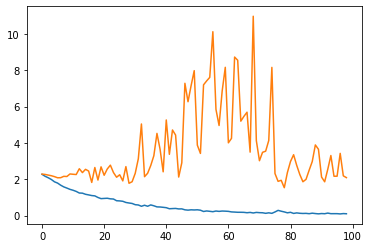

Fold 1 runtime: 114.74465727806091
FOLD # 2
Begin Training
Completed training batch 0 Train Loss: 2.2896 Val Loss: 2.2178 Train Accuracy: 10.0000 Val Accuracy: 14.0000
Completed training batch 1 Train Loss: 2.1993 Val Loss: 2.1713 Train Accuracy: 19.0000 Val Accuracy: 15.0000
Completed training batch 2 Train Loss: 2.1332 Val Loss: 2.1247 Train Accuracy: 24.2500 Val Accuracy: 16.0000
Completed training batch 3 Train Loss: 2.0356 Val Loss: 2.0650 Train Accuracy: 25.2500 Val Accuracy: 26.0000
Completed training batch 4 Train Loss: 1.9594 Val Loss: 1.9934 Train Accuracy: 29.7500 Val Accuracy: 31.0000
Completed training batch 5 Train Loss: 1.8618 Val Loss: 1.9405 Train Accuracy: 33.0000 Val Accuracy: 34.0000
Completed training batch 6 Train Loss: 1.7657 Val Loss: 1.8953 Train Accuracy: 35.7500 Val Accuracy: 32.0000
Completed training batch 7 Train Loss: 1.7145 Val Loss: 1.8513 Train Accuracy: 36.5000 Val Accuracy: 30.0000
Completed training batch 8 Train Loss: 1.6283 Val Loss: 1.8109 Train 

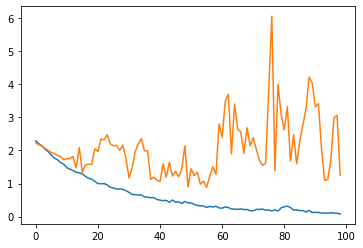

Fold 2 runtime: 113.04156184196472
FOLD # 3
Begin Training
Completed training batch 0 Train Loss: 2.2897 Val Loss: 2.2424 Train Accuracy: 13.2500 Val Accuracy: 18.0000
Completed training batch 1 Train Loss: 2.2094 Val Loss: 2.1910 Train Accuracy: 22.5000 Val Accuracy: 19.0000
Completed training batch 2 Train Loss: 2.1397 Val Loss: 2.1389 Train Accuracy: 24.0000 Val Accuracy: 25.0000
Completed training batch 3 Train Loss: 2.0604 Val Loss: 2.0765 Train Accuracy: 25.2500 Val Accuracy: 28.0000
Completed training batch 4 Train Loss: 1.9698 Val Loss: 2.0106 Train Accuracy: 28.2500 Val Accuracy: 29.0000
Completed training batch 5 Train Loss: 1.8581 Val Loss: 1.9525 Train Accuracy: 34.2500 Val Accuracy: 34.0000
Completed training batch 6 Train Loss: 1.7654 Val Loss: 1.8963 Train Accuracy: 36.7500 Val Accuracy: 39.0000
Completed training batch 7 Train Loss: 1.6902 Val Loss: 1.8114 Train Accuracy: 38.2500 Val Accuracy: 42.0000
Completed training batch 8 Train Loss: 1.5957 Val Loss: 1.8703 Train 

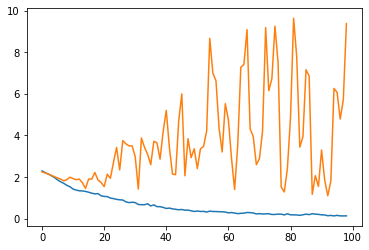

Fold 3 runtime: 112.8069224357605
FOLD # 4
Begin Training
Completed training batch 0 Train Loss: 2.2876 Val Loss: 2.2464 Train Accuracy: 16.0000 Val Accuracy: 16.0000
Completed training batch 1 Train Loss: 2.2115 Val Loss: 2.1978 Train Accuracy: 22.2500 Val Accuracy: 29.0000
Completed training batch 2 Train Loss: 2.1559 Val Loss: 2.1509 Train Accuracy: 21.5000 Val Accuracy: 30.0000
Completed training batch 3 Train Loss: 2.0656 Val Loss: 2.1002 Train Accuracy: 28.2500 Val Accuracy: 26.0000
Completed training batch 4 Train Loss: 1.9761 Val Loss: 2.0443 Train Accuracy: 31.0000 Val Accuracy: 26.0000
Completed training batch 5 Train Loss: 1.9065 Val Loss: 1.9804 Train Accuracy: 33.7500 Val Accuracy: 31.0000
Completed training batch 6 Train Loss: 1.8213 Val Loss: 1.9220 Train Accuracy: 32.0000 Val Accuracy: 34.0000
Completed training batch 7 Train Loss: 1.7250 Val Loss: 1.8905 Train Accuracy: 37.5000 Val Accuracy: 31.0000
Completed training batch 8 Train Loss: 1.6773 Val Loss: 1.9081 Train A

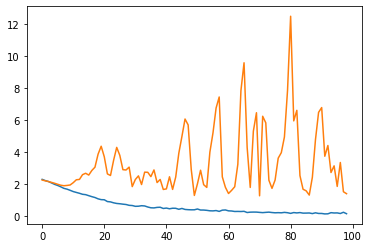

Fold 4 runtime: 112.85380172729492
FOLD # 5
Begin Training
Completed training batch 0 Train Loss: 2.2713 Val Loss: 2.2508 Train Accuracy: 14.0000 Val Accuracy: 15.0000
Completed training batch 1 Train Loss: 2.1879 Val Loss: 2.1910 Train Accuracy: 26.5000 Val Accuracy: 20.0000
Completed training batch 2 Train Loss: 2.1361 Val Loss: 2.1438 Train Accuracy: 27.2500 Val Accuracy: 25.0000
Completed training batch 3 Train Loss: 2.0188 Val Loss: 2.0814 Train Accuracy: 31.7500 Val Accuracy: 26.0000
Completed training batch 4 Train Loss: 1.9108 Val Loss: 2.0215 Train Accuracy: 31.5000 Val Accuracy: 28.0000
Completed training batch 5 Train Loss: 1.8195 Val Loss: 1.9756 Train Accuracy: 36.7500 Val Accuracy: 28.0000
Completed training batch 6 Train Loss: 1.7079 Val Loss: 1.9350 Train Accuracy: 36.5000 Val Accuracy: 29.0000
Completed training batch 7 Train Loss: 1.6727 Val Loss: 1.9369 Train Accuracy: 34.7500 Val Accuracy: 25.0000
Completed training batch 8 Train Loss: 1.5827 Val Loss: 1.9867 Train 

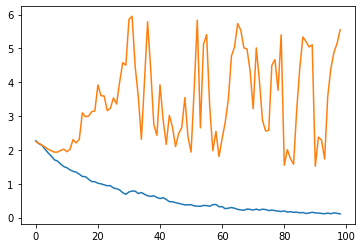

Fold 5 runtime: 112.99965572357178


In [ ]:
RATE = 22050
transform_melspec = transforms.MelSpectrogram(sample_rate=RATE, n_fft=1024, n_mels=60)

net = CNN(input_channels=1)
net.to(device)

print(device)

lr=0.001
criterion = nn.CrossEntropyLoss()

name = 'CNN_MelSpec'
train_loss_dict, val_loss_dict, batch_runtimes, mean_accuracy = train_cv(100,
                                                                         esc50_human, 
                                                                         net,
                                                                         lr=lr,
                                                                         model_name=name,
                                                                         transform_1=transform_melspec)

In [ ]:
# show mean validation accuracy over all folds and best epochs
print(f"Mean runtime per fold (s): {np.round(np.mean(batch_runtimes))}")
print(f"Mean val accuracy: {np.round(mean_accuracy, 2)}")

Mean runtime per fold (s): 100.0
Mean val accuracy: 73.2


Best Fold Accuracy: 76.0


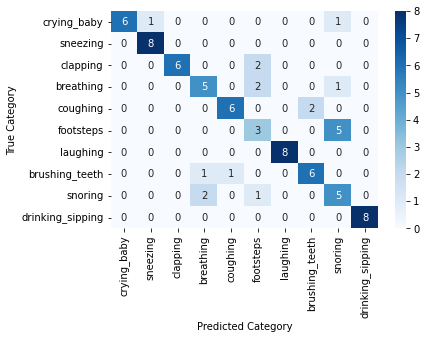

In [ ]:
RATE = 22050

dataloader_dic = get_dataloader_dict(esc50_human)
transform_melspec = transforms.MelSpectrogram(sample_rate=RATE, n_fft=1024, n_mels=60)
X_train, y_train, X_val, y_val = train_val_loader(dataloader_dic, fold=2)

val_dataset = ESCHDataset(X_val,
                  y_val,
                  transform_1=transform_melspec)


val_loader = DataLoader(val_dataset, batch_size=80, drop_last=True,
                        worker_init_fn=seed_worker, 
                        generator=g)

iteritems = iter(val_loader)
data, y_true = next(iteritems)


PATH = "models/CNN_MelSpec_fold_2_.pth"
model = CNN(input_channels=1)
model.to(device)
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

model.eval()
y_pred = model(data)
y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
_, y_pred_tags = torch.max(y_pred_softmax, dim = 1)

conf_mat = confusion_matrix(y_true, y_pred_tags)

ax = sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=plot_labels, yticklabels=plot_labels)
ax.set(xlabel="Predicted Category", ylabel="True Category")

print(f"Best Fold Accuracy: {multi_acc(y_pred, y_true)}")

#### CNN on Melspectrogram + Deltas

cuda
FOLD # 1
Begin Training
Completed training batch 0 Train Loss: 2.2612 Val Loss: 2.2851 Train Accuracy: 13.2500 Val Accuracy: 15.0000
Completed training batch 1 Train Loss: 2.1721 Val Loss: 2.2691 Train Accuracy: 20.2500 Val Accuracy: 15.0000
Completed training batch 2 Train Loss: 2.1195 Val Loss: 2.2347 Train Accuracy: 21.0000 Val Accuracy: 30.0000
Completed training batch 3 Train Loss: 2.0352 Val Loss: 2.2015 Train Accuracy: 29.0000 Val Accuracy: 28.0000
Completed training batch 4 Train Loss: 1.9213 Val Loss: 2.1834 Train Accuracy: 33.0000 Val Accuracy: 24.0000
Completed training batch 5 Train Loss: 1.8664 Val Loss: 2.1660 Train Accuracy: 30.5000 Val Accuracy: 26.0000
Completed training batch 6 Train Loss: 1.7714 Val Loss: 2.1061 Train Accuracy: 32.7500 Val Accuracy: 28.0000
Completed training batch 7 Train Loss: 1.6925 Val Loss: 2.1409 Train Accuracy: 35.7500 Val Accuracy: 24.0000
Completed training batch 8 Train Loss: 1.5898 Val Loss: 2.1294 Train Accuracy: 42.5000 Val Accuracy

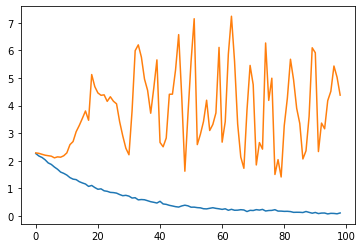

Fold 1 runtime: 120.06407308578491
FOLD # 2
Begin Training
Completed training batch 0 Train Loss: 2.2858 Val Loss: 2.2432 Train Accuracy: 14.5000 Val Accuracy: 12.0000
Completed training batch 1 Train Loss: 2.2043 Val Loss: 2.1988 Train Accuracy: 23.0000 Val Accuracy: 24.0000
Completed training batch 2 Train Loss: 2.1253 Val Loss: 2.1463 Train Accuracy: 26.0000 Val Accuracy: 26.0000
Completed training batch 3 Train Loss: 1.9991 Val Loss: 2.0730 Train Accuracy: 32.7500 Val Accuracy: 32.0000
Completed training batch 4 Train Loss: 1.9220 Val Loss: 1.9983 Train Accuracy: 32.5000 Val Accuracy: 32.0000
Completed training batch 5 Train Loss: 1.7885 Val Loss: 1.9174 Train Accuracy: 36.0000 Val Accuracy: 32.0000
Completed training batch 6 Train Loss: 1.7222 Val Loss: 1.8385 Train Accuracy: 34.5000 Val Accuracy: 30.0000
Completed training batch 7 Train Loss: 1.6576 Val Loss: 1.8336 Train Accuracy: 35.0000 Val Accuracy: 29.0000
Completed training batch 8 Train Loss: 1.5706 Val Loss: 1.8092 Train 

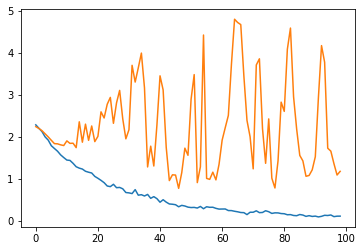

Fold 2 runtime: 120.06210446357727
FOLD # 3
Begin Training
Completed training batch 0 Train Loss: 2.2906 Val Loss: 2.2330 Train Accuracy: 15.7500 Val Accuracy: 10.0000
Completed training batch 1 Train Loss: 2.1956 Val Loss: 2.1767 Train Accuracy: 22.5000 Val Accuracy: 20.0000
Completed training batch 2 Train Loss: 2.1315 Val Loss: 2.1331 Train Accuracy: 24.5000 Val Accuracy: 20.0000
Completed training batch 3 Train Loss: 2.0643 Val Loss: 2.0735 Train Accuracy: 27.5000 Val Accuracy: 29.0000
Completed training batch 4 Train Loss: 1.9628 Val Loss: 2.0117 Train Accuracy: 29.0000 Val Accuracy: 31.0000
Completed training batch 5 Train Loss: 1.9017 Val Loss: 1.9566 Train Accuracy: 30.7500 Val Accuracy: 35.0000
Completed training batch 6 Train Loss: 1.8075 Val Loss: 1.8812 Train Accuracy: 29.2500 Val Accuracy: 40.0000
Completed training batch 7 Train Loss: 1.7023 Val Loss: 1.8080 Train Accuracy: 38.0000 Val Accuracy: 42.0000
Completed training batch 8 Train Loss: 1.6122 Val Loss: 1.7334 Train 

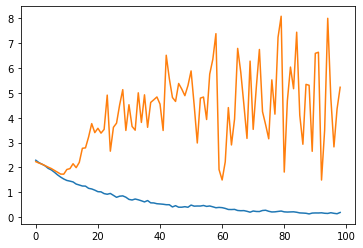

Fold 3 runtime: 121.11802387237549
FOLD # 4
Begin Training
Completed training batch 0 Train Loss: 2.2846 Val Loss: 2.2316 Train Accuracy: 12.2500 Val Accuracy: 16.0000
Completed training batch 1 Train Loss: 2.1998 Val Loss: 2.1917 Train Accuracy: 22.5000 Val Accuracy: 20.0000
Completed training batch 2 Train Loss: 2.1315 Val Loss: 2.1524 Train Accuracy: 25.7500 Val Accuracy: 28.0000
Completed training batch 3 Train Loss: 2.0212 Val Loss: 2.1106 Train Accuracy: 29.2500 Val Accuracy: 26.0000
Completed training batch 4 Train Loss: 1.9293 Val Loss: 2.0464 Train Accuracy: 32.0000 Val Accuracy: 31.0000
Completed training batch 5 Train Loss: 1.8403 Val Loss: 1.9851 Train Accuracy: 34.7500 Val Accuracy: 31.0000
Completed training batch 6 Train Loss: 1.7633 Val Loss: 1.9492 Train Accuracy: 35.7500 Val Accuracy: 30.0000
Completed training batch 7 Train Loss: 1.6865 Val Loss: 2.0091 Train Accuracy: 37.5000 Val Accuracy: 30.0000
Completed training batch 8 Train Loss: 1.6239 Val Loss: 2.0695 Train 

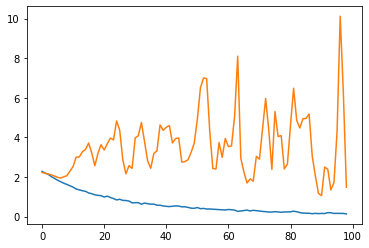

Fold 4 runtime: 120.78414392471313
FOLD # 5
Begin Training
Completed training batch 0 Train Loss: 2.2797 Val Loss: 2.2465 Train Accuracy: 13.5000 Val Accuracy: 12.0000
Completed training batch 1 Train Loss: 2.1938 Val Loss: 2.2046 Train Accuracy: 21.5000 Val Accuracy: 24.0000
Completed training batch 2 Train Loss: 2.1288 Val Loss: 2.1570 Train Accuracy: 24.5000 Val Accuracy: 22.0000
Completed training batch 3 Train Loss: 2.0341 Val Loss: 2.1158 Train Accuracy: 27.5000 Val Accuracy: 21.0000
Completed training batch 4 Train Loss: 1.9535 Val Loss: 2.0839 Train Accuracy: 33.2500 Val Accuracy: 22.0000
Completed training batch 5 Train Loss: 1.8575 Val Loss: 2.0524 Train Accuracy: 34.5000 Val Accuracy: 25.0000
Completed training batch 6 Train Loss: 1.7755 Val Loss: 2.0122 Train Accuracy: 33.5000 Val Accuracy: 28.0000
Completed training batch 7 Train Loss: 1.6940 Val Loss: 1.9679 Train Accuracy: 39.7500 Val Accuracy: 26.0000
Completed training batch 8 Train Loss: 1.6219 Val Loss: 1.9414 Train 

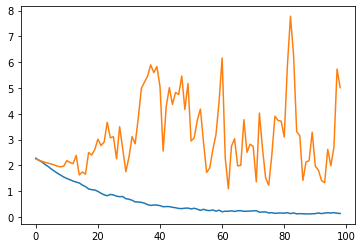

Fold 5 runtime: 121.49071288108826


In [ ]:
RATE = 22050
transform_melspec = transforms.MelSpectrogram(sample_rate=RATE, n_fft=1024, n_mels=60)
transform_deltas = transforms.ComputeDeltas()

net = CNN(input_channels=2)
net.to(device)

print(device)

lr=0.001
criterion = nn.CrossEntropyLoss()

name = 'CNN_MelSpec_Deltas'
train_loss_dict, val_loss_dict, batch_runtimes, mean_accuracy = train_cv(100,
                                                                         esc50_human, 
                                                                         net,
                                                                         lr=lr,
                                                                         model_name=name,
                                                                         transform_1=transform_melspec,
                                                                         transform_2=transform_deltas)

In [ ]:
# show mean validation accuracy over all folds and best epochs
print(f"Mean runtime per fold (s): {np.round(np.mean(batch_runtimes))}")
print(f"Mean val accuracy: {np.round(mean_accuracy, 2)}")

Mean runtime per fold (s): 121.0
Mean val accuracy: 73.0


Best Fold Accuracy: 78.0


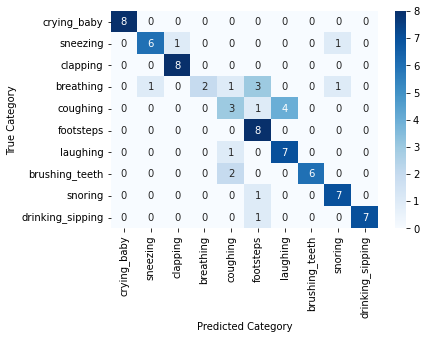

In [ ]:
RATE = 22050

dataloader_dic = get_dataloader_dict(esc50_human)
transform_melspec = transforms.MelSpectrogram(sample_rate=RATE, n_fft=1024, n_mels=60)
transform_deltas = transforms.ComputeDeltas()

X_train, y_train, X_val, y_val = train_val_loader(dataloader_dic, fold=4)

val_dataset = ESCHDataset(X_val,
                  y_val,
                  transform_1=transform_melspec,
                  transform_2=transform_deltas)


val_loader = DataLoader(val_dataset, batch_size=80, drop_last=True,
                        worker_init_fn=seed_worker, 
                        generator=g)

iteritems = iter(val_loader)
data, y_true = next(iteritems)


PATH = "models/CNN_MelSpec_Deltas_fold_4_.pth"
model = CNN(input_channels=2)
model.to(device)
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

model.eval()
y_pred = model(data)
y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
_, y_pred_tags = torch.max(y_pred_softmax, dim = 1)

conf_mat = confusion_matrix(y_true, y_pred_tags)

ax = sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=plot_labels, yticklabels=plot_labels)
ax.set(xlabel="Predicted Category", ylabel="True Category")

print(f"Best Fold Accuracy: {multi_acc(y_pred, y_true)}")

#### CNN on Melspectrogram + Deltas + Augmentations



cuda
FOLD # 1
Begin Training
Completed training batch 0 Train Loss: 2.3063 Val Loss: 2.3278 Train Accuracy: 10.7500 Val Accuracy: 5.0000
Completed training batch 1 Train Loss: 2.3066 Val Loss: 2.3241 Train Accuracy: 10.5000 Val Accuracy: 5.0000
Completed training batch 2 Train Loss: 2.2997 Val Loss: 2.3173 Train Accuracy: 10.2500 Val Accuracy: 11.0000
Completed training batch 3 Train Loss: 2.2963 Val Loss: 2.3172 Train Accuracy: 12.7500 Val Accuracy: 11.0000
Completed training batch 4 Train Loss: 2.2946 Val Loss: 2.3167 Train Accuracy: 12.0000 Val Accuracy: 8.0000
Completed training batch 5 Train Loss: 2.2899 Val Loss: 2.3127 Train Accuracy: 12.7500 Val Accuracy: 11.0000
Completed training batch 6 Train Loss: 2.2918 Val Loss: 2.3121 Train Accuracy: 12.2500 Val Accuracy: 6.0000
Completed training batch 7 Train Loss: 2.2840 Val Loss: 2.3072 Train Accuracy: 13.2500 Val Accuracy: 8.0000
Completed training batch 8 Train Loss: 2.2861 Val Loss: 2.3021 Train Accuracy: 12.7500 Val Accuracy: 9.0

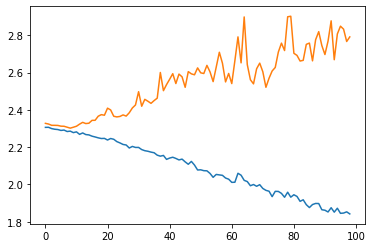

Fold 1 runtime: 1930.1393690109253
FOLD # 2
Begin Training
Completed training batch 0 Train Loss: 2.3131 Val Loss: 2.3426 Train Accuracy: 10.0000 Val Accuracy: 2.0000
Completed training batch 1 Train Loss: 2.3032 Val Loss: 2.3559 Train Accuracy: 11.2500 Val Accuracy: 5.0000
Completed training batch 2 Train Loss: 2.3062 Val Loss: 2.3385 Train Accuracy: 11.5000 Val Accuracy: 8.0000
Completed training batch 3 Train Loss: 2.3011 Val Loss: 2.3191 Train Accuracy: 11.2500 Val Accuracy: 11.0000
Completed training batch 4 Train Loss: 2.3001 Val Loss: 2.3125 Train Accuracy: 11.7500 Val Accuracy: 12.0000
Completed training batch 5 Train Loss: 2.3003 Val Loss: 2.3196 Train Accuracy: 12.5000 Val Accuracy: 10.0000
Completed training batch 6 Train Loss: 2.2939 Val Loss: 2.3299 Train Accuracy: 11.7500 Val Accuracy: 8.0000
Completed training batch 7 Train Loss: 2.2923 Val Loss: 2.3334 Train Accuracy: 13.2500 Val Accuracy: 0.0000
Completed training batch 8 Train Loss: 2.2908 Val Loss: 2.3360 Train Accur

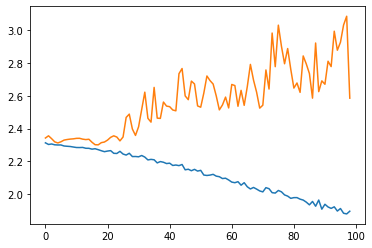

Fold 2 runtime: 1911.9352505207062
FOLD # 3
Begin Training
Completed training batch 0 Train Loss: 2.3154 Val Loss: 2.3122 Train Accuracy: 10.2500 Val Accuracy: 10.0000
Completed training batch 1 Train Loss: 2.3034 Val Loss: 2.3174 Train Accuracy: 10.2500 Val Accuracy: 12.0000
Completed training batch 2 Train Loss: 2.3009 Val Loss: 2.3135 Train Accuracy: 12.2500 Val Accuracy: 12.0000
Completed training batch 3 Train Loss: 2.2975 Val Loss: 2.3108 Train Accuracy: 12.0000 Val Accuracy: 20.0000
Completed training batch 4 Train Loss: 2.2983 Val Loss: 2.3155 Train Accuracy: 11.0000 Val Accuracy: 8.0000
Completed training batch 5 Train Loss: 2.2965 Val Loss: 2.3130 Train Accuracy: 12.2500 Val Accuracy: 9.0000
Completed training batch 6 Train Loss: 2.2967 Val Loss: 2.3086 Train Accuracy: 12.2500 Val Accuracy: 15.0000
Completed training batch 7 Train Loss: 2.2911 Val Loss: 2.3049 Train Accuracy: 12.7500 Val Accuracy: 18.0000
Completed training batch 8 Train Loss: 2.2933 Val Loss: 2.2939 Train Ac

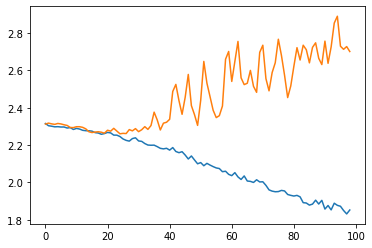

Fold 3 runtime: 1907.0529472827911
FOLD # 4
Begin Training
Completed training batch 0 Train Loss: 2.3089 Val Loss: 2.3262 Train Accuracy: 10.2500 Val Accuracy: 0.0000
Completed training batch 1 Train Loss: 2.3015 Val Loss: 2.3291 Train Accuracy: 11.7500 Val Accuracy: 1.0000
Completed training batch 2 Train Loss: 2.2946 Val Loss: 2.3250 Train Accuracy: 11.7500 Val Accuracy: 5.0000
Completed training batch 3 Train Loss: 2.2904 Val Loss: 2.3284 Train Accuracy: 13.0000 Val Accuracy: 6.0000
Completed training batch 4 Train Loss: 2.2928 Val Loss: 2.3277 Train Accuracy: 12.0000 Val Accuracy: 10.0000
Completed training batch 5 Train Loss: 2.2907 Val Loss: 2.3255 Train Accuracy: 11.7500 Val Accuracy: 12.0000
Completed training batch 6 Train Loss: 2.2868 Val Loss: 2.3180 Train Accuracy: 11.0000 Val Accuracy: 11.0000
Completed training batch 7 Train Loss: 2.2771 Val Loss: 2.3156 Train Accuracy: 13.0000 Val Accuracy: 12.0000
Completed training batch 8 Train Loss: 2.2795 Val Loss: 2.3108 Train Accu

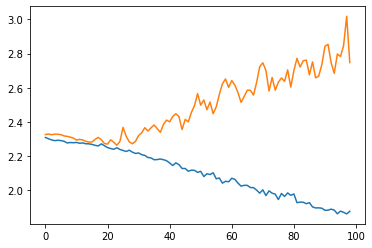

Fold 4 runtime: 1898.8874843120575
FOLD # 5
Begin Training
Completed training batch 0 Train Loss: 2.3123 Val Loss: 2.3024 Train Accuracy: 9.5000 Val Accuracy: 11.0000
Completed training batch 1 Train Loss: 2.3045 Val Loss: 2.3124 Train Accuracy: 10.7500 Val Accuracy: 11.0000
Completed training batch 2 Train Loss: 2.3040 Val Loss: 2.3165 Train Accuracy: 11.2500 Val Accuracy: 14.0000
Completed training batch 3 Train Loss: 2.3010 Val Loss: 2.3128 Train Accuracy: 10.7500 Val Accuracy: 11.0000
Completed training batch 4 Train Loss: 2.3004 Val Loss: 2.3095 Train Accuracy: 11.0000 Val Accuracy: 9.0000
Completed training batch 5 Train Loss: 2.2968 Val Loss: 2.3074 Train Accuracy: 11.0000 Val Accuracy: 6.0000
Completed training batch 6 Train Loss: 2.2932 Val Loss: 2.3104 Train Accuracy: 12.0000 Val Accuracy: 6.0000
Completed training batch 7 Train Loss: 2.2944 Val Loss: 2.3152 Train Accuracy: 11.2500 Val Accuracy: 6.0000
Completed training batch 8 Train Loss: 2.2913 Val Loss: 2.3216 Train Accur

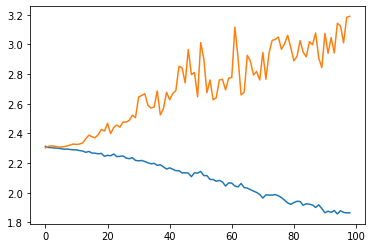

Fold 5 runtime: 1886.46888422966


In [ ]:
RATE = 22050
augmentation = ComposeMany(
    [
        RandomApply([Noise(min_snr=0.01, max_snr=0.05)], p=0.5),
        RandomApply([HighLowPass(sample_rate=RATE)], p=0.5),
        RandomApply([Delay(sample_rate=RATE, min_delay=50, max_delay=55)], p=0.5)
    ], num_augmented_samples=5)
transform_melspec = transforms.MelSpectrogram(sample_rate=RATE, n_fft=1024, n_mels=60)
transform_deltas = transforms.ComputeDeltas()

net = CNN(input_channels=2)
net.to(device)
print(device)

lr=0.001
criterion = nn.CrossEntropyLoss()

name = 'CNN_MelSpec_Deltas_Augmentations'
train_loss_dict, val_loss_dict, batch_runtimes, mean_accuracy = train_cv(100,
                                                                         # change the name of the df to the frames
                                                                         esc50_human, 
                                                                         net,
                                                                         lr=lr,
                                                                         model_name=name,
                                                                         augmentation=augmentation,
                                                                         transform_1=transform_melspec,
                                                                         transform_2=transform_deltas,
                                                                         is_augmented=True)

In [ ]:
# show mean validation accuracy over all folds and best epochs
print(f"Mean runtime per fold (s): {np.round(np.mean(batch_runtimes))}")
print(f"Mean val accuracy: {np.round(mean_accuracy, 2)}")

Mean runtime per fold (s): 1907.0
Mean val accuracy: 20.4


#### CNN on Melspectrogram + Deltas on Trimmed Audios

cuda
FOLD # 1
Begin Training
Completed training batch 0 Train Loss: 2.2924 Val Loss: 2.2652 Train Accuracy: 12.5417 Val Accuracy: 15.3333
Completed training batch 1 Train Loss: 2.1772 Val Loss: 2.2055 Train Accuracy: 16.9167 Val Accuracy: 18.3333
Completed training batch 2 Train Loss: 2.1389 Val Loss: 2.1787 Train Accuracy: 18.2917 Val Accuracy: 18.8333
Completed training batch 3 Train Loss: 2.0902 Val Loss: 2.1486 Train Accuracy: 20.5000 Val Accuracy: 19.5000
Completed training batch 4 Train Loss: 2.0352 Val Loss: 2.1228 Train Accuracy: 23.3750 Val Accuracy: 23.5000
Completed training batch 5 Train Loss: 1.9884 Val Loss: 2.0565 Train Accuracy: 27.1667 Val Accuracy: 21.0000
Completed training batch 6 Train Loss: 1.8892 Val Loss: 2.0735 Train Accuracy: 31.7083 Val Accuracy: 24.3333
Completed training batch 7 Train Loss: 1.8157 Val Loss: 2.3589 Train Accuracy: 32.7083 Val Accuracy: 22.8333
Completed training batch 8 Train Loss: 1.7507 Val Loss: 2.3881 Train Accuracy: 37.1667 Val Accuracy

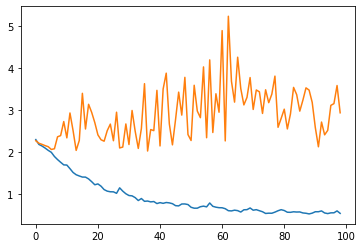

Fold 1 runtime: 167.77291536331177
FOLD # 2
Begin Training
Completed training batch 0 Train Loss: 2.3003 Val Loss: 2.2263 Train Accuracy: 8.5417 Val Accuracy: 19.6667
Completed training batch 1 Train Loss: 2.1771 Val Loss: 2.1145 Train Accuracy: 16.1667 Val Accuracy: 19.0000
Completed training batch 2 Train Loss: 2.1350 Val Loss: 2.1103 Train Accuracy: 18.0833 Val Accuracy: 20.8333
Completed training batch 3 Train Loss: 2.0624 Val Loss: 2.1533 Train Accuracy: 22.4167 Val Accuracy: 19.6667
Completed training batch 4 Train Loss: 2.0028 Val Loss: 2.1663 Train Accuracy: 26.1250 Val Accuracy: 21.5000
Completed training batch 5 Train Loss: 1.9489 Val Loss: 2.4166 Train Accuracy: 28.9583 Val Accuracy: 21.0000
Completed training batch 6 Train Loss: 1.8859 Val Loss: 2.2213 Train Accuracy: 31.1667 Val Accuracy: 23.3333
Completed training batch 7 Train Loss: 1.8472 Val Loss: 2.3839 Train Accuracy: 34.8750 Val Accuracy: 24.5000
Completed training batch 8 Train Loss: 1.7985 Val Loss: 2.4838 Train A

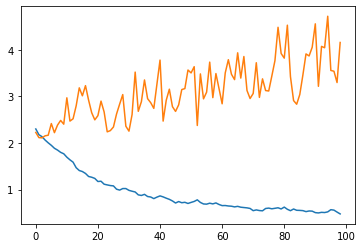

Fold 2 runtime: 166.80704545974731
FOLD # 3
Begin Training
Completed training batch 0 Train Loss: 2.3100 Val Loss: 2.2358 Train Accuracy: 10.2500 Val Accuracy: 19.6667
Completed training batch 1 Train Loss: 2.2079 Val Loss: 2.1302 Train Accuracy: 16.8750 Val Accuracy: 19.1667
Completed training batch 2 Train Loss: 2.1533 Val Loss: 2.0879 Train Accuracy: 18.6250 Val Accuracy: 20.5000
Completed training batch 3 Train Loss: 2.1177 Val Loss: 2.0391 Train Accuracy: 19.9167 Val Accuracy: 22.8333
Completed training batch 4 Train Loss: 2.0592 Val Loss: 2.1080 Train Accuracy: 24.4583 Val Accuracy: 24.1667
Completed training batch 5 Train Loss: 1.9979 Val Loss: 2.2169 Train Accuracy: 27.9583 Val Accuracy: 26.1667
Completed training batch 6 Train Loss: 1.9450 Val Loss: 2.4123 Train Accuracy: 30.4583 Val Accuracy: 26.3333
Completed training batch 7 Train Loss: 1.8978 Val Loss: 2.4462 Train Accuracy: 30.8333 Val Accuracy: 27.8333
Completed training batch 8 Train Loss: 1.8498 Val Loss: 1.9330 Train 

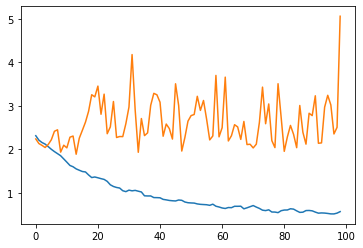

Fold 3 runtime: 166.8450026512146
FOLD # 4
Begin Training
Completed training batch 0 Train Loss: 2.3122 Val Loss: 2.2487 Train Accuracy: 10.0000 Val Accuracy: 12.6667
Completed training batch 1 Train Loss: 2.2310 Val Loss: 2.1620 Train Accuracy: 15.2083 Val Accuracy: 16.8333
Completed training batch 2 Train Loss: 2.1609 Val Loss: 2.1339 Train Accuracy: 16.9583 Val Accuracy: 21.1667
Completed training batch 3 Train Loss: 2.1159 Val Loss: 2.1428 Train Accuracy: 19.9583 Val Accuracy: 16.6667
Completed training batch 4 Train Loss: 2.0617 Val Loss: 2.2341 Train Accuracy: 23.8750 Val Accuracy: 19.0000
Completed training batch 5 Train Loss: 2.0275 Val Loss: 2.2252 Train Accuracy: 27.4167 Val Accuracy: 19.5000
Completed training batch 6 Train Loss: 1.9683 Val Loss: 2.2823 Train Accuracy: 29.8750 Val Accuracy: 19.6667
Completed training batch 7 Train Loss: 1.8899 Val Loss: 2.4904 Train Accuracy: 34.2083 Val Accuracy: 21.8333
Completed training batch 8 Train Loss: 1.8310 Val Loss: 2.6886 Train A

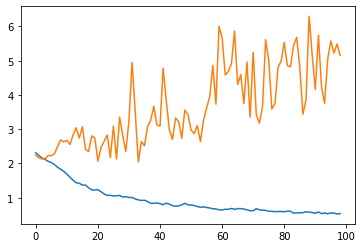

Fold 4 runtime: 165.346684217453
FOLD # 5
Begin Training
Completed training batch 0 Train Loss: 2.3081 Val Loss: 2.2317 Train Accuracy: 11.9167 Val Accuracy: 15.8333
Completed training batch 1 Train Loss: 2.2188 Val Loss: 2.1852 Train Accuracy: 15.9583 Val Accuracy: 19.0000
Completed training batch 2 Train Loss: 2.1633 Val Loss: 2.1431 Train Accuracy: 19.2083 Val Accuracy: 21.0000
Completed training batch 3 Train Loss: 2.1186 Val Loss: 2.1155 Train Accuracy: 19.9583 Val Accuracy: 19.6667
Completed training batch 4 Train Loss: 2.0804 Val Loss: 2.0710 Train Accuracy: 24.3750 Val Accuracy: 25.3333
Completed training batch 5 Train Loss: 2.0364 Val Loss: 2.0648 Train Accuracy: 26.3750 Val Accuracy: 23.6667
Completed training batch 6 Train Loss: 1.9562 Val Loss: 2.2637 Train Accuracy: 29.8750 Val Accuracy: 23.0000
Completed training batch 7 Train Loss: 1.8661 Val Loss: 2.2851 Train Accuracy: 32.5000 Val Accuracy: 24.5000
Completed training batch 8 Train Loss: 1.7701 Val Loss: 2.7914 Train Ac

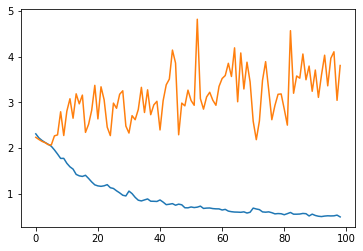

Fold 5 runtime: 164.94035172462463


In [ ]:
RATE = 22050
transform_melspec = transforms.MelSpectrogram(sample_rate=RATE, n_fft=1024, n_mels=60)
transform_deltas = transforms.ComputeDeltas()

net = CNN(input_channels=2)
net.to(device)
print(device)

lr=0.001
criterion = nn.CrossEntropyLoss()

name = 'CNN_MelSpec_Deltas_Trimmed'
train_loss_dict, val_loss_dict, batch_runtimes, mean_accuracy = train_cv(100,
                                                                         # change the name of the df to the frames
                                                                         esc50_human_frames, 
                                                                         net,
                                                                         lr=lr,
                                                                         model_name=name,
                                                                         transform_1=transform_melspec,
                                                                         transform_2=transform_deltas)

In [ ]:
# show mean validation accuracy over all folds and best epochs
print(f"Mean runtime per fold (s): {np.round(np.mean(batch_runtimes))}")
print(f"Mean val accuracy: {np.round(mean_accuracy, 2)}")

Mean runtime per fold (s): 166.0
Mean val accuracy: 40.83


### CNN-LSTM

In [ ]:
class ESCHTIMEDataset(Dataset):
    def __init__(self, data, targets, augmentation=None, transform_1=None, transform_2=None):
        self.data = data
        self.targets = targets
        self.augmentation = augmentation
        self.transform_1 = transform_1
        self.transform_2 = transform_2
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        frames = []

        if self.augmentation:
            x = self.augmentation(x)
        
        if self.transform_1:
            x = self.transform_1(x)
            if self.transform_2:
                x_1 = self.transform_2(x)
                if self.augmentation:
                    x = torch.cat((x, x_1), 1)
                else:
                    x = torch.cat((x, x_1), 0)                
            frame_len = 44 // 3 # 44 is the lenght of the melspectogram
            overlap = frame_len // 2
            c = 0
            for _ in range(0, 44, 44//3):
              frame = x[:, :, c:frame_len + c]
              c += overlap
              frames.append(frame)
        # concatenate all sequences of same audio as channels of tensor
        x = torch.cat(frames, dim=0)
        return x, y
    
    def __len__(self):
        return len(self.data)

In [ ]:
import torch
import torch.nn as nn


class CNNLSTM(nn.Module):
    """
    The idea is that the CNN sees bath_size * 4 (eg: 80*4) images independently. Each image is a segment of the original audio.
    The Conv layers capture important features from them. Later, an LSTM processes these features in a sequence of 
    lenght 4 (the original channel dimesion of the tensor)
    The LSTM to captures the time dependendy between segments of the audio. We take the last state of the LSTM and
    pass it through a couple of FC layers to make a prediction.
    """
    def __init__(self):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.3)

        self.lstm = nn.LSTM(input_size=2880, hidden_size=128, num_layers=3, 
                            dropout=0.3, bidirectional=True, batch_first=True) # (batch, seq, feature)

        self.fc1 = nn.Linear(in_features=256, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        x = x.view(80*4, 1, 60, 14)
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.dropout1(x)
        x = x.view(80, 4, -1)
        lstm_out, _ = self.lstm(x)
        x = F.relu(self.fc1(lstm_out[:, -1]))
        x = self.dropout1(x)
        x = self.fc2(x)        
        return x

cuda
FOLD # 1
Begin Training
Completed training batch 0 Train Loss: 2.3018 Val Loss: 2.2974 Train Accuracy: 12.5000 Val Accuracy: 15.0000
Completed training batch 1 Train Loss: 2.2799 Val Loss: 2.2759 Train Accuracy: 18.2500 Val Accuracy: 18.0000
Completed training batch 2 Train Loss: 2.2232 Val Loss: 2.2479 Train Accuracy: 17.2500 Val Accuracy: 16.0000
Completed training batch 3 Train Loss: 2.1320 Val Loss: 2.2647 Train Accuracy: 21.5000 Val Accuracy: 14.0000
Completed training batch 4 Train Loss: 2.0862 Val Loss: 2.2849 Train Accuracy: 21.0000 Val Accuracy: 15.0000
Completed training batch 5 Train Loss: 2.0543 Val Loss: 2.2215 Train Accuracy: 23.7500 Val Accuracy: 16.0000
Completed training batch 6 Train Loss: 2.0147 Val Loss: 2.1939 Train Accuracy: 23.0000 Val Accuracy: 19.0000
Completed training batch 7 Train Loss: 1.9544 Val Loss: 2.1840 Train Accuracy: 27.7500 Val Accuracy: 21.0000
Completed training batch 8 Train Loss: 1.9185 Val Loss: 2.1398 Train Accuracy: 25.7500 Val Accuracy

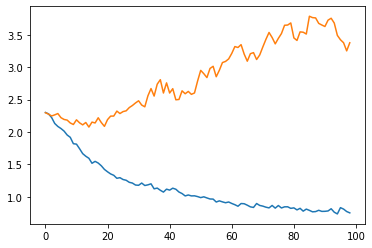

Fold 1 runtime: 83.83682298660278
FOLD # 2
Begin Training
Completed training batch 0 Train Loss: 2.3020 Val Loss: 2.2975 Train Accuracy: 11.2500 Val Accuracy: 18.0000
Completed training batch 1 Train Loss: 2.2827 Val Loss: 2.2801 Train Accuracy: 19.7500 Val Accuracy: 15.0000
Completed training batch 2 Train Loss: 2.2311 Val Loss: 2.2449 Train Accuracy: 16.0000 Val Accuracy: 15.0000
Completed training batch 3 Train Loss: 2.1510 Val Loss: 2.2253 Train Accuracy: 17.0000 Val Accuracy: 12.0000
Completed training batch 4 Train Loss: 2.1289 Val Loss: 2.2037 Train Accuracy: 19.7500 Val Accuracy: 16.0000
Completed training batch 5 Train Loss: 2.0490 Val Loss: 2.1426 Train Accuracy: 23.0000 Val Accuracy: 19.0000
Completed training batch 6 Train Loss: 1.9936 Val Loss: 2.1727 Train Accuracy: 24.0000 Val Accuracy: 19.0000
Completed training batch 7 Train Loss: 1.9577 Val Loss: 2.2466 Train Accuracy: 26.7500 Val Accuracy: 30.0000
Completed training batch 8 Train Loss: 1.9335 Val Loss: 2.2365 Train A

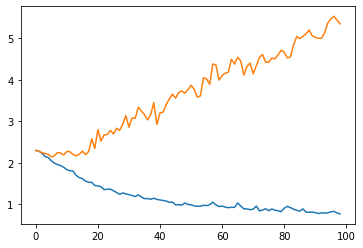

Fold 2 runtime: 83.09119081497192
FOLD # 3
Begin Training
Completed training batch 0 Train Loss: 2.3014 Val Loss: 2.2939 Train Accuracy: 10.0000 Val Accuracy: 10.0000
Completed training batch 1 Train Loss: 2.2868 Val Loss: 2.2701 Train Accuracy: 13.0000 Val Accuracy: 19.0000
Completed training batch 2 Train Loss: 2.2520 Val Loss: 2.2153 Train Accuracy: 19.2500 Val Accuracy: 18.0000
Completed training batch 3 Train Loss: 2.1967 Val Loss: 2.1214 Train Accuracy: 19.7500 Val Accuracy: 21.0000
Completed training batch 4 Train Loss: 2.1277 Val Loss: 2.0425 Train Accuracy: 22.7500 Val Accuracy: 28.0000
Completed training batch 5 Train Loss: 2.0639 Val Loss: 1.9924 Train Accuracy: 24.7500 Val Accuracy: 24.0000
Completed training batch 6 Train Loss: 2.0122 Val Loss: 1.9496 Train Accuracy: 24.5000 Val Accuracy: 29.0000
Completed training batch 7 Train Loss: 1.9293 Val Loss: 1.9044 Train Accuracy: 30.2500 Val Accuracy: 31.0000
Completed training batch 8 Train Loss: 1.8898 Val Loss: 1.8649 Train A

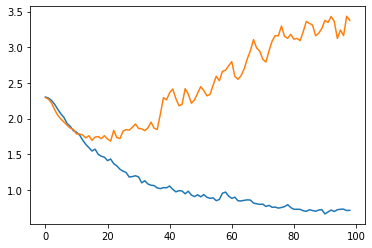

Fold 3 runtime: 83.99786353111267
FOLD # 4
Begin Training
Completed training batch 0 Train Loss: 2.3040 Val Loss: 2.2997 Train Accuracy: 10.0000 Val Accuracy: 11.0000
Completed training batch 1 Train Loss: 2.2928 Val Loss: 2.2828 Train Accuracy: 11.7500 Val Accuracy: 15.0000
Completed training batch 2 Train Loss: 2.2643 Val Loss: 2.2454 Train Accuracy: 16.2500 Val Accuracy: 14.0000
Completed training batch 3 Train Loss: 2.2014 Val Loss: 2.1937 Train Accuracy: 18.5000 Val Accuracy: 16.0000
Completed training batch 4 Train Loss: 2.1582 Val Loss: 2.1514 Train Accuracy: 17.5000 Val Accuracy: 19.0000
Completed training batch 5 Train Loss: 2.1296 Val Loss: 2.1158 Train Accuracy: 20.0000 Val Accuracy: 21.0000
Completed training batch 6 Train Loss: 2.0363 Val Loss: 2.0657 Train Accuracy: 25.0000 Val Accuracy: 19.0000
Completed training batch 7 Train Loss: 1.9993 Val Loss: 2.0188 Train Accuracy: 29.7500 Val Accuracy: 30.0000
Completed training batch 8 Train Loss: 1.9326 Val Loss: 1.9942 Train A

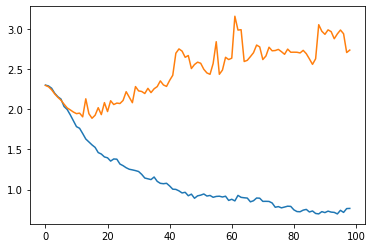

Fold 4 runtime: 83.4669668674469
FOLD # 5
Begin Training
Completed training batch 0 Train Loss: 2.3031 Val Loss: 2.2985 Train Accuracy: 11.5000 Val Accuracy: 16.0000
Completed training batch 1 Train Loss: 2.2911 Val Loss: 2.2783 Train Accuracy: 16.0000 Val Accuracy: 18.0000
Completed training batch 2 Train Loss: 2.2591 Val Loss: 2.2251 Train Accuracy: 17.2500 Val Accuracy: 22.0000
Completed training batch 3 Train Loss: 2.1995 Val Loss: 2.1354 Train Accuracy: 20.7500 Val Accuracy: 22.0000
Completed training batch 4 Train Loss: 2.1325 Val Loss: 2.0449 Train Accuracy: 22.7500 Val Accuracy: 21.0000
Completed training batch 5 Train Loss: 2.0201 Val Loss: 1.9819 Train Accuracy: 28.2500 Val Accuracy: 22.0000
Completed training batch 6 Train Loss: 1.9896 Val Loss: 1.9506 Train Accuracy: 26.0000 Val Accuracy: 19.0000
Completed training batch 7 Train Loss: 1.9772 Val Loss: 1.9326 Train Accuracy: 26.5000 Val Accuracy: 25.0000
Completed training batch 8 Train Loss: 1.8968 Val Loss: 1.8819 Train Ac

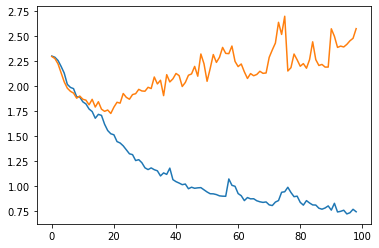

Fold 5 runtime: 83.61398267745972


In [ ]:
RATE = 22050
transform_melspec = transforms.MelSpectrogram(sample_rate=RATE, n_fft=1024, n_mels=60)

net = CNNLSTM()
net.to(device)
print(device)

lr=0.001
criterion = nn.CrossEntropyLoss()

name = 'CNNLSTM_MelSpec'
train_loss_dict, val_loss_dict, batch_runtimes, mean_accuracy = train_cv(100,
                                                                         esc50_human, 
                                                                         net,
                                                                         lr=lr,
                                                                         model_name=name,
                                                                         transform_1=transform_melspec,
                                                                         cnn_lstm=True)

In [ ]:
# show mean validation accuracy over all folds and best epochs
print(f"Mean runtime per fold (s): {np.round(np.mean(batch_runtimes))}")
print(f"Mean val accuracy: {np.round(mean_accuracy, 2)}")

Mean runtime per fold (s): 84.0
Mean val accuracy: 38.8


In [ ]:
import gc
net = None
model = None
gc.collect()

torch.cuda.empty_cache()